In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import shutil
import math
import time

from IPython.display import display
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
import numpy as np
import scipy as sp
import cv2 as cv

In [3]:
# CANNY EDGE DETECTOR

class CannyDetector():
    
    def __init__(self, blursize=5, sigma=1.2, sobelsize=3, weakthr=0.1, strongthr=0.25):
        self.blursize = blursize
        self.sigma = sigma
        self.sobelsize = sobelsize
        self.weakthr = weakthr
        self.strongthr = strongthr
    
    def _blur(self, img):
        sz = (self.blursize, self.blursize)
        return cv.GaussianBlur(img, sz, self.sigma)
    
    def _sobel(self, img):
        sobx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=self.sobelsize)
        soby = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=self.sobelsize)
        
        mag = np.sqrt(sobx**2 + soby**2)
        dr = np.arctan2(sobx, soby)
        dr = (np.round(dr/math.pi * 4 + 4.0) ).astype(int)
        return mag, dr
    
#     def _threshold_matrix(self, mag, dr):
#         # non-maxima supression
#         # FAST!
#         angles = np.linspace(0, (7/4)*math.pi, 8)
#         dy = [0, 1, 1, 1, 0, -1, -1, -1]
#         dx = [1, 1, 0, -1, -1, -1, 0, 1]
        
#         to_sup = np.zeros_like(mag).astype(bool)
#         for i,ang in enumerate(angles):
#             mask = np.abs(dr - ang) < math.pi/4
#             temp = ( mag <= np.roll(mag, (dy[i], dx[i])) )
#             d1 = mag < np.roll(mag, (dy[i], dx[i]))
#             to_sup |= d1 & mask
#             d2 = mag <= np.roll(mag, (-dy[i], -dx[i]))
#             to_sup |= d2 & mask
#             #showimg(mask, ang)
#             #showimg(to_sup, ang)
        
#         # double threshold
#         mag[to_sup] = 0
#         mag[mag < self.weakthr] = 0
#         strong = mag > self.strongthr
#         weak = (mag > 0)
#         return strong, weak
    
    def _threshold(self, mag, dr):
        
        dy = list(reversed([1, 1, 0, -1, -1, -1, 0, 1, 1]))
        dx= list(reversed([0, -1, -1, -1, 0, 1, 1, 1, 0]))
        
        edges = np.zeros_like(mag)
        
        for y in range(1, mag.shape[0]-1):
            for x in range(1, mag.shape[1]-1):
                i = dr[y, x]
                q = mag[y + dy[i], x + dx[i]]
                r =  mag[y - dy[i], x - dx[i]]
                if mag[y, x] >= q and mag[y, x] >= r:
                    edges[y, x] = mag[y, x]
                    
        return edges
    
    
    def _link(self, edges):
        strong = edges > self.strongthr
        weak = edges > self.weakthr
        
        ker = np.ones((3,3))
        for y in range(strong.shape[0]):
            for x in range(strong.shape[1]):
                is_weak = weak[y, x]
                strongnbh = strong[y-1:y+2, x-1:x+2]
                is_strong = np.sum(strongnbh) * is_weak
                if is_strong > 0:
                    strong[y, x] = True
        return strong
    
    def __call__(self, img):
        img = self._blur(img)
        mag, dr = self._sobel(img)
        edges = self._threshold(mag, dr)
        linked = self._link(edges)
        return linked
    
def canny_builtin(img):
    return cv.Canny(img, 50, 200)
    

def showimg(img, title=""):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()



# TEST CIRCLE
# img_int = np.zeros((500, 500))
# img_int = cv.circle(img, (250, 250), 150, (255, 255, 255), 10)
# img = img_int.astype(float) / np.max(img_int)
# img_int = np.uint8(img_int)



        
        

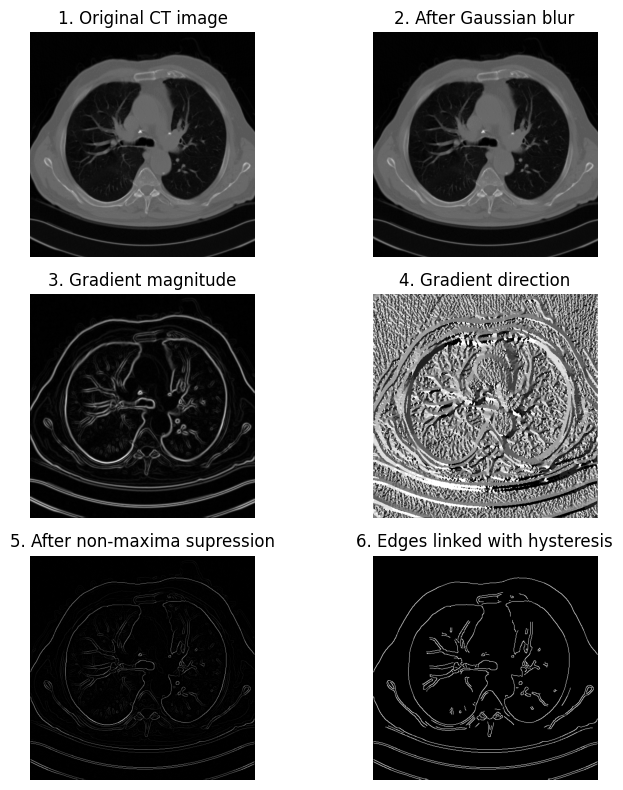

In [6]:
# STAGES

def showsub(img, title=""):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(title)

figsize(8, 8)

img_int = cv.cvtColor(cv.imread("data/3.png"), cv.COLOR_BGR2GRAY)
img = img_int.astype(float) / np.max(img_int)

plt.subplot(3, 2, 1)
showsub(img, "1. Original CT image")
canny = CannyDetector()
blurred = canny._blur(img)
plt.subplot(3, 2, 2)
showsub(img, "2. After Gaussian blur")
mag, dr = canny._sobel(blurred)
plt.subplot(3, 2, 3)
showsub(mag, "3. Gradient magnitude")
plt.subplot(3, 2, 4)
showsub(dr, "4. Gradient direction")
edges = canny._threshold(mag, dr)
plt.subplot(3, 2, 5)
showsub(edges, "5. After non-maxima supression")
linked = canny._link(edges)
plt.subplot(3, 2, 6)
showsub(linked, "6. Edges linked with hysteresis")

plt.tight_layout()
plt.show()


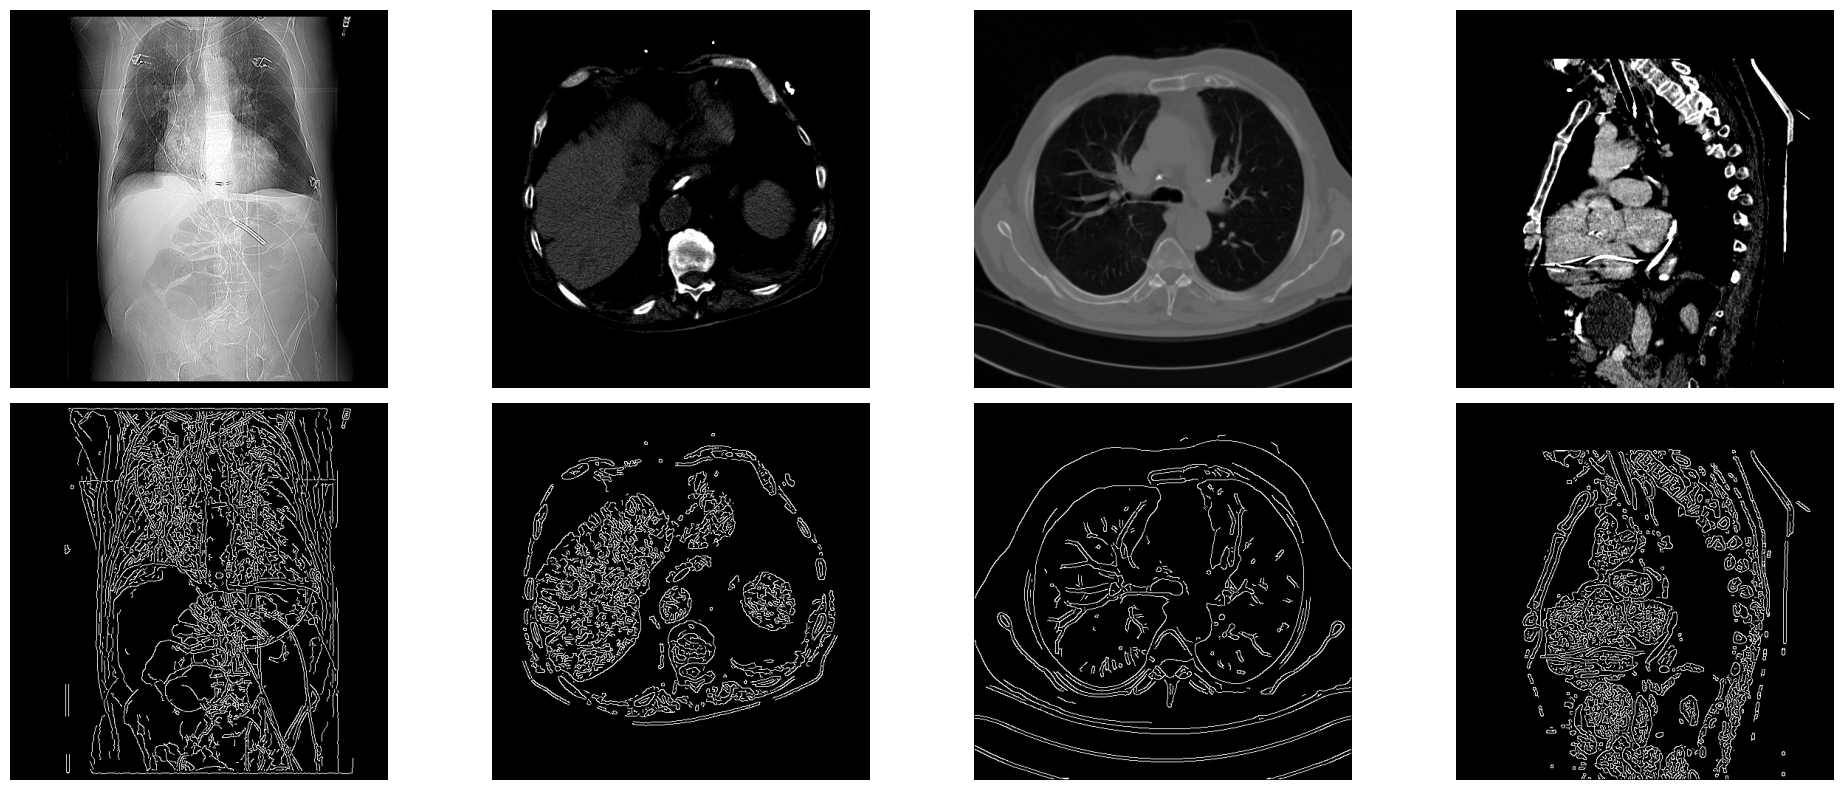

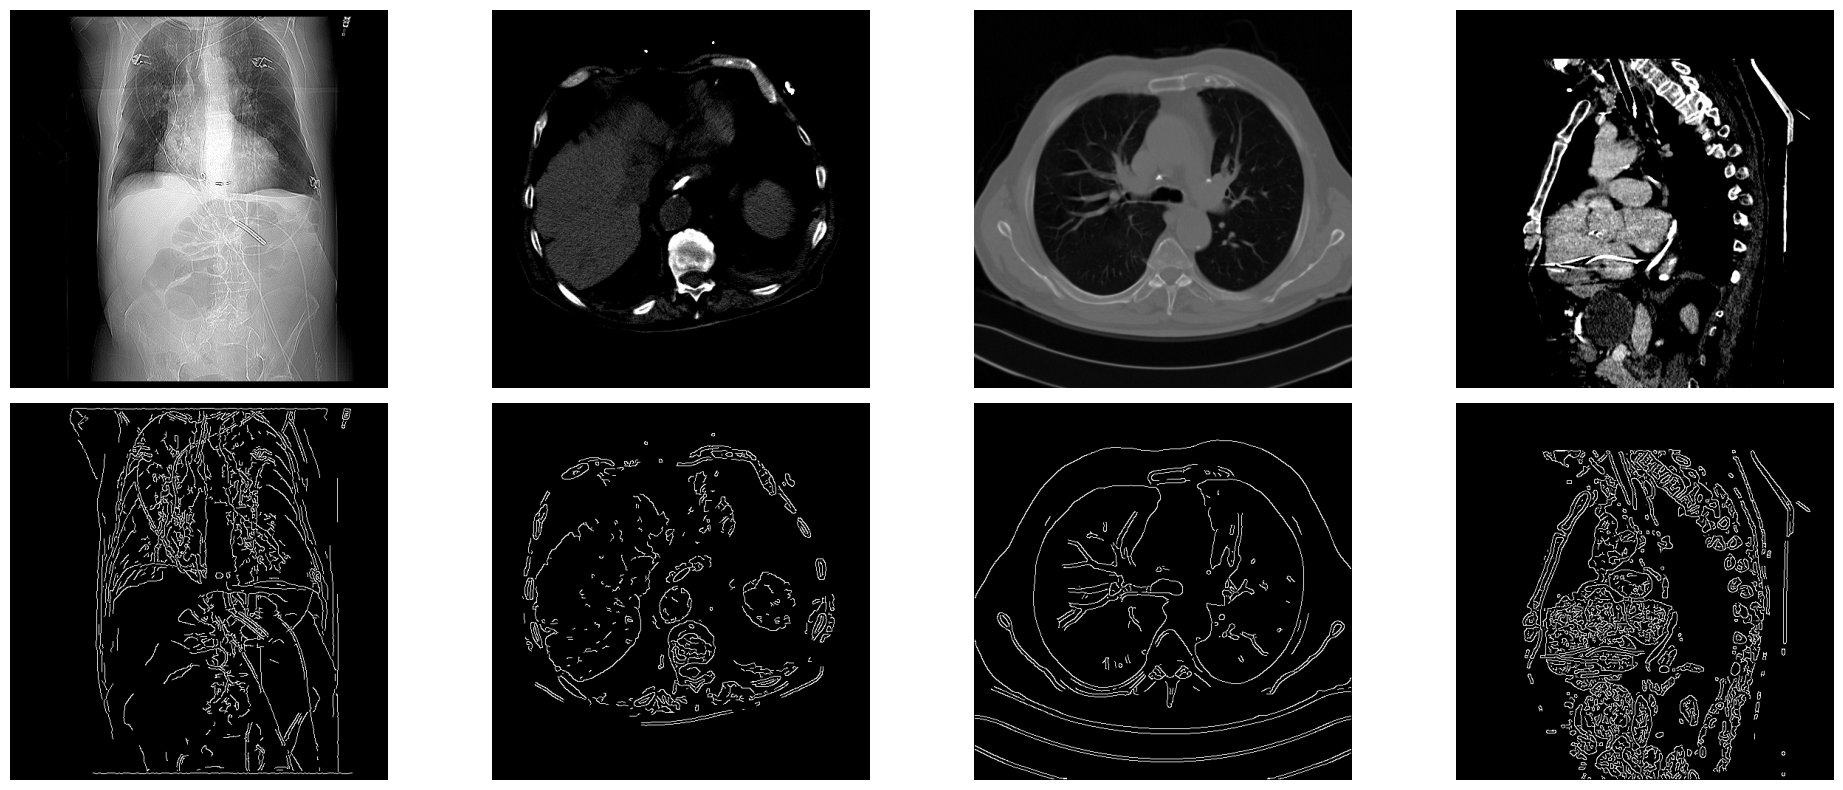

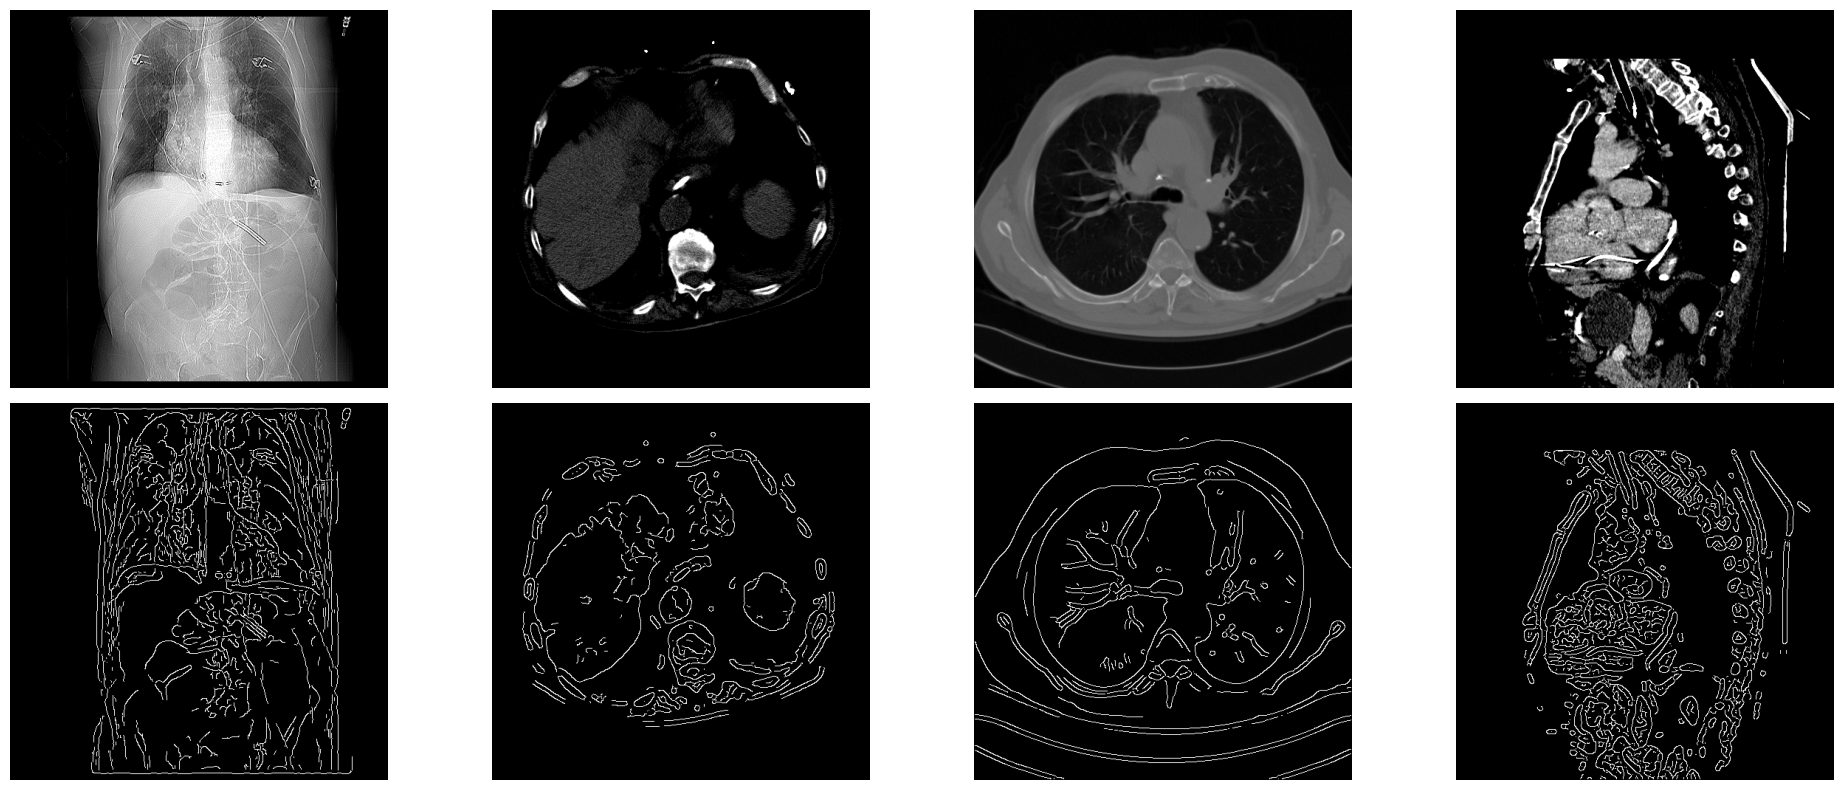

In [7]:
# EXAMPLES

def loadimg(pth): 
    img_int = cv.cvtColor(cv.imread(pth), cv.COLOR_BGR2GRAY)
    img = img_int.astype(float) / np.max(img_int)
    return img

def showall(canny):
    n = 4
    imgs = [loadimg(f"data/{i}.png") for i in range(1, n+1)]

    figsize(20, 8)
    for i in range(0, n):
        plt.subplot(2, n, i+1)
        showsub(imgs[i])
        edges = canny(imgs[i])
        img = np.uint8(imgs[i]*255)
        plt.subplot(2, n, n+i+1)
        showsub(edges)
    plt.tight_layout()
    plt.show()

canny = CannyDetector(blursize=5, sigma=1.5, sobelsize=3, weakthr=0.04, strongthr=0.12)
showall(canny)

canny = CannyDetector(blursize=5, sigma=1.5, sobelsize=3, weakthr=0.1, strongthr=0.2)
showall(canny)

canny = CannyDetector(blursize=9, sigma=2.5, sobelsize=3, weakthr=0.04, strongthr=0.08)
showall(canny)
